In [0]:
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt

content_image_path = 'content_.png'
style_image_path = 'style.jpg'

width, height = load_img(content_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:

from keras import backend as K

target_image = K.constant(preprocess_image(content_image_path))
style_image = K.constant(preprocess_image(style_image_path))

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensors = K.concatenate([target_image,style_image,combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensors,
                    weights='imagenet',
                    include_top=False)


In [0]:
def content_loss(gen_image,content_img):
    H, W, C = gen_image.get_shape().as_list()

    a_C_unrolled = tf.reshape(content_img,[H*W,C])

    a_G_unrolled = tf.reshape(gen_image,[H*W,C])
    
 
    J_content = tf.reduce_sum(np.square(a_C_unrolled-a_G_unrolled))
 
    
    return J_content# Now, here's the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e. a map of the correlations found in the original feature matrix.

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(matrix):
    mat = K.batch_flatten(K.permute_dimensions(matrix, (2, 0, 1)))
    gram = tf.matmul(mat, tf.transpose(mat))
    return gram


def style_loss(style, gen_img):
    S = gram_matrix(style)
    C = gram_matrix(gen_img)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [14]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_img_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_img_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

op_function = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None        

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = op_function([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Start of iteration 0
Current loss value: 1608176500.0


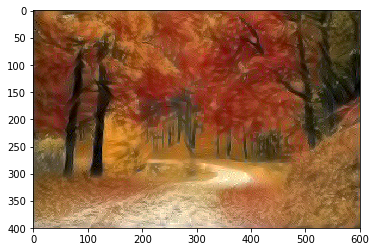

Start of iteration 1
Current loss value: 690754370.0


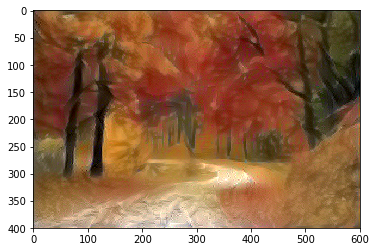

Start of iteration 2
Current loss value: 466534000.0


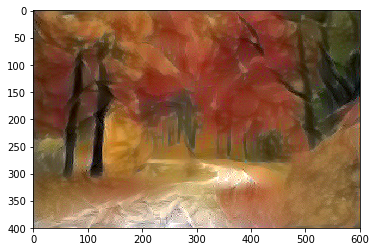

Start of iteration 3
Current loss value: 367151170.0


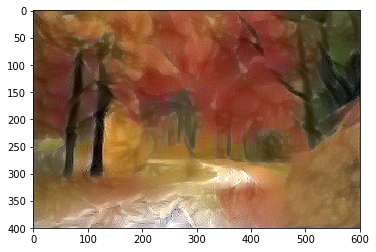

Start of iteration 4
Current loss value: 313535550.0


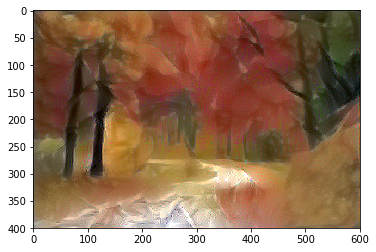

Start of iteration 5
Current loss value: 279149470.0


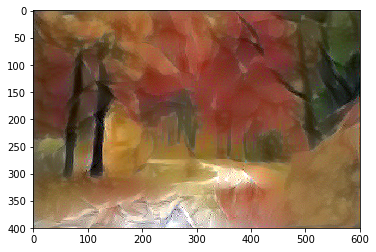

Start of iteration 6
Current loss value: 256360900.0


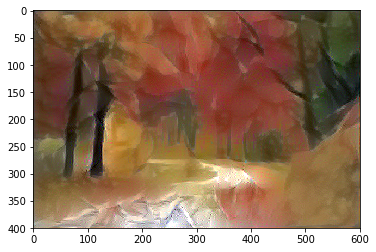

Start of iteration 7
Current loss value: 239029420.0


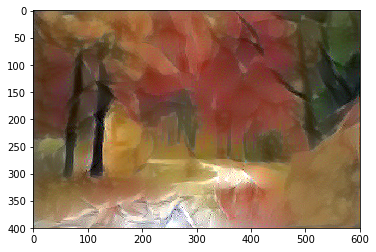

Start of iteration 8
Current loss value: 224868200.0


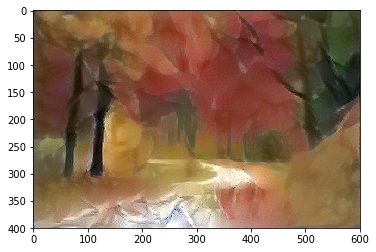

Start of iteration 9
Current loss value: 213895940.0


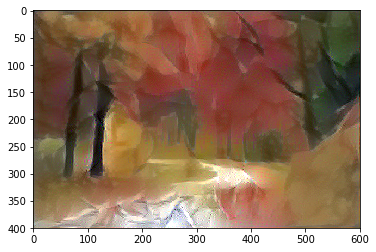

Start of iteration 10
Current loss value: 205011000.0


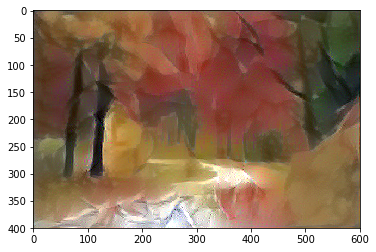

Start of iteration 11
Current loss value: 197563280.0


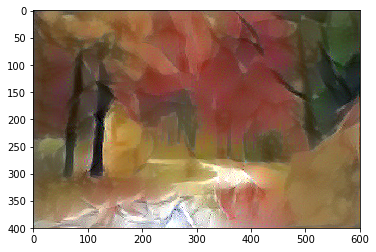

Start of iteration 12
Current loss value: 190940860.0


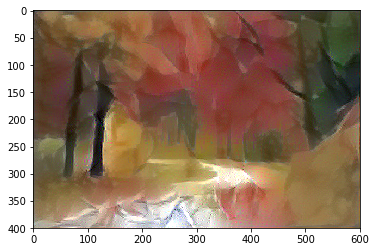

Start of iteration 13
Current loss value: 184734300.0


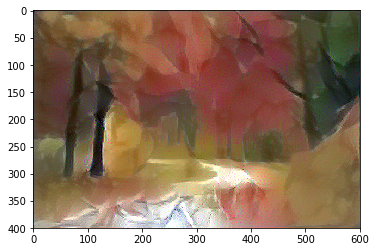

Start of iteration 14
Current loss value: 179698460.0


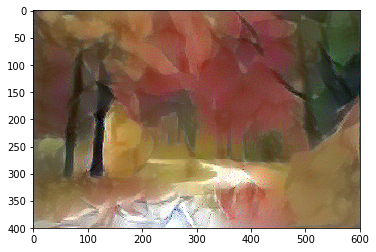

Start of iteration 15
Current loss value: 175399360.0


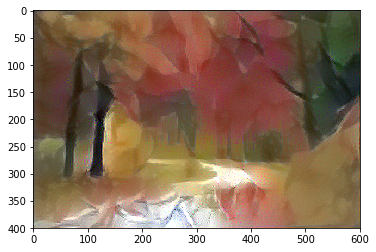

Start of iteration 16
Current loss value: 170840500.0


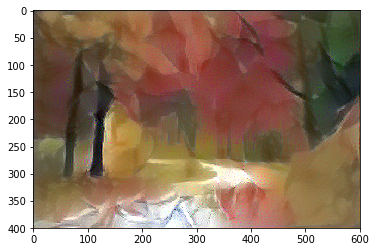

Start of iteration 17
Current loss value: 167165800.0


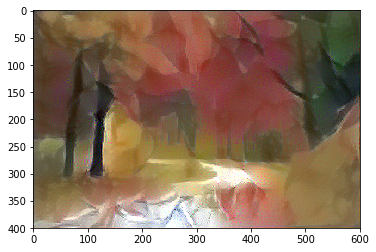

Start of iteration 18
Current loss value: 163563420.0


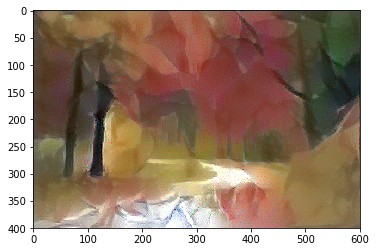

Start of iteration 19
Current loss value: 160076240.0


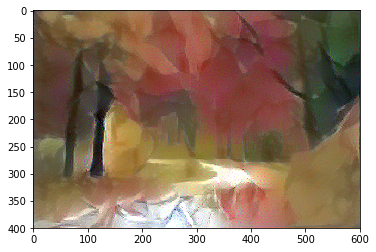

In [16]:
from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20


x = preprocess_image(content_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    # start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    # fname = result_prefix + '_at_iteration_%d.png' % i
    
    # end_time = time.time()
    plt.imshow(img) # plot the generated image agfter every epoch
    plt.show()
    